# Распознавание рукописного текста и капчи

Импортируем необходимые библиотеки:

In [51]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda
from keras.layers import Activation,BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Загружаем данные

In [52]:
train = pd.read_csv('C:/Users/lenas/Downloads/written_name_train_v2.csv')
valid = pd.read_csv('C:/Users/lenas/Downloads/written_name_validation_v2.csv')

Просмотрим несколько изображений

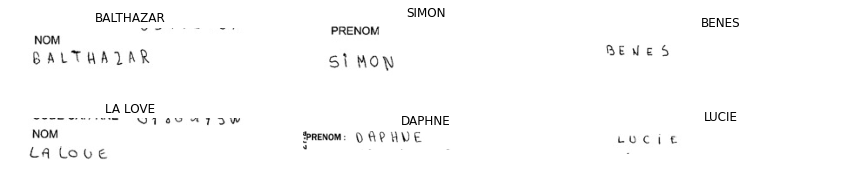

In [53]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/lenas/Downloads/train_v2/train/'+ train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

Проверим наличие пустых значений в нашем наборе.

In [54]:
print("Количество пустых значений в train set: ", train['IDENTITY'].isnull().sum())
print("Количество пустых значений в validation set : ", valid['IDENTITY'].isnull().sum())

Количество пустых значений в train set:  565
Количество пустых значений в validation set :  78


Удалим пустые значения.

In [55]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Кроме того, после проверки выяснилось, что в наших данных есть некоторые изображения с пометкой "нечитаемые". 

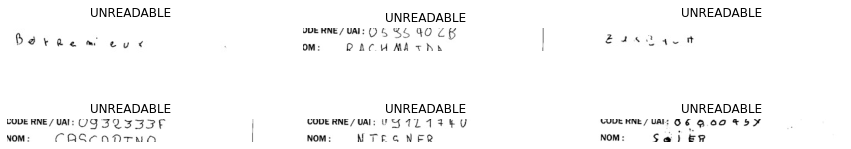

In [56]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/lenas/Downloads/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

Удалим их.

In [57]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

В наборе существуют некоторые надписи, которые написаны в нижнем регистре. Чтобы сохранить единообразие в надписях, я преобразовываю все надписи в верхний регистр.

In [58]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [59]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

На данном этапе мы закончили с очисткой данных.
И переходим к предварительной обработке и подготовке изображений к обучению.
Изображения загружаются в оттенках серого и изменяются до ширины 256 и высоты 64.
Ширина и высота обрезаются, если они больше 256 и 64 соответственно. Если они меньше, то изображение дополняется белыми пикселями. Наконец, изображение поворачивается по часовой стрелке, чтобы придать изображению форму (x, y).
Затем изображение нормализуется до диапазона [0, 1]

In [60]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255
    
    # обрезка 
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [61]:
train_size = 30000
valid_size= 3000

In [62]:
train_x = []

for i in range(train_size):
    img_dir = 'C:/Users/lenas/Downloads/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [63]:
valid_x = []

for i in range(valid_size):
    img_dir = 'C:/Users/lenas/Downloads/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [64]:
np.array(train_x).shape

(30000, 256, 64)

In [65]:
np.array(valid_x).shape

(3000, 256, 64)

In [66]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [67]:
train_x.shape

(30000, 256, 64, 1)

In [68]:
valid_x.shape

(3000, 256, 64, 1)

Подготовка к CTC Loss
Метки должны быть преобразованы в числа, которые представляют каждый символ в обучающем наборе. "Алфавит" состоят из букв от А до Я и трех специальных символов (- ' и пробел).


In [69]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # максимальная длина входных меток
num_of_characters = len(alphabets) + 1 # +1 для псевдопустых меток ctc
num_of_timestamps = 64 # максимальная длина прогнозируемых меток

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [70]:
name = 'ELENA'
print(name, '\n',label_to_num(name))

ELENA 
 [ 4 11  4 13  0]


- train_y содержит истинные метки, преобразованные в числа и дополненные значением -1. Длина каждой метки равна max_str_len.
- train_label_len содержит длину каждой истинной метки (без заполнения)
- train_input_len содержит длину каждой предсказанной метки. Длина всех предсказанных меток постоянна, т.е. количество временных меток - 2.
- train_output - фиктивный вывод для CTC Loss.


In [71]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])  

In [72]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY']) 

In [73]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


Построение нашей модели

In [74]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 64, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

Модель предсказывает слова из 64 символов, и каждый символ содержит вероятность 30 алфавитов, которые мы определили ранее.

In [75]:
# функция ctc loss 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # 2 здесь имеет решающее значение, так как первая пара выходов RNN
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [76]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

Обучение модели

In [77]:
%%time
# вычисление L0ss происходит в другом месте, поэтому мы используем фиктивную лямбда-функцию для Loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=128)

C:\Users\lenas\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
Cause: could not parse the source code of <function <lambda> at 0x000001BD46AD3CA0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001BD46AD3CA0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
235/235 [==============================] - 2130s 9s/step - loss: 25.2260 - val_loss: 20.7143
Epoch 2/30
235/235 [==============================] - 1414s 6s/step - loss: 20.1514 - val_loss: 20.0980
Epoch 3/30
235/235 [==============================] - 1593s 7s/step - loss: 19.8190 - val_loss: 19.7722
Epoch 4/30
235/235 [==============================] - 1440s 6s/step - loss: 19.4489 - val_loss: 19.3000
Epoch 5/30
235/235 [==============================] - 1484s 6s/step - loss: 18.7975 - val_loss: 18.6355
Epoch 6/30
235/235 [====================

Проверим производительность модели на validation set

In [78]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [79]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Предсказанные правильные символы :  : %.2f%%' %(correct_char*100/total_char))
print('Предсказанные правильные слова :       : %.2f%%' %(correct*100/valid_size))

Предсказанные правильные символы :  : 69.76%
Предсказанные правильные слова :       : 53.30%


Некоторые распознавания по тестовому набору

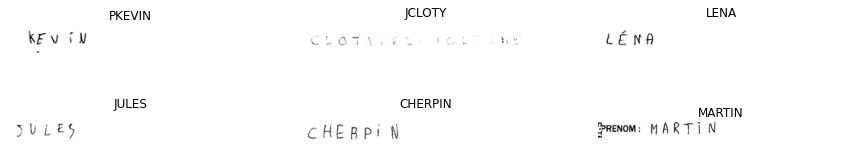

In [80]:
test = pd.read_csv('C:/Users/lenas/Downloads/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/lenas/Downloads/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# Распознавание капчи

Решение 1 - сочетает в себе классификатор CNN и FC и обеспечивает довольно хорошую производительность ( 94%):
-	обрезаем изображение вокруг символов и переворачивает обрезанное изображение (так как мы хотим, чтобы измерение времени соответствовало ширине изображения).
-	используем CNN для извлечения объектов из обрезанного изображения.
-	изменяем форму объектов, чтобы разделить их на 5 временных шагов.
-	используем классификатор FC для прогнозирования 5 символов: для каждого временного шага выводом является распределение вероятностей нахождения символа на этом шаге.

Решение 2 - реализует архитектуру CNN LSTM с функцией CTC и обеспечивает высокую производительность (99%):
-	переворачиваем входное изображение (так как мы хотим, чтобы "измерение времени" соответствовало ширине изображения).
-	используем CNN для извлечения объектов из изображения.
-	используем кодировщик CNN (который состоит из одного полностью подключенного слоя) для кодирования объектов в 50 временных шагов, используем 2 BRNN для обработки последовательности из 50 шагов: для каждого временного шага выходным результатом является распределение вероятности нахождения символа на этом шаге.
-	используем декодер CTC для прогнозирования 5 символов.


Импортируем необходимые библиотеки:

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_folder = 'C:/Users/lenas/Downloads/samples/samples/'

Набор данных содержит 1070 файлов. Каждый файл представляет собой изображение, представляющее изображение CAPTCHA. Изображение либо в формате png (1040 файлов png), либо в формате jpg (30 файлов jpg). Имя файла состоит из 5 символов, содержащихся в изображении CAPTCHA, за которым следует формат изображения (например, 2g7nm.png).

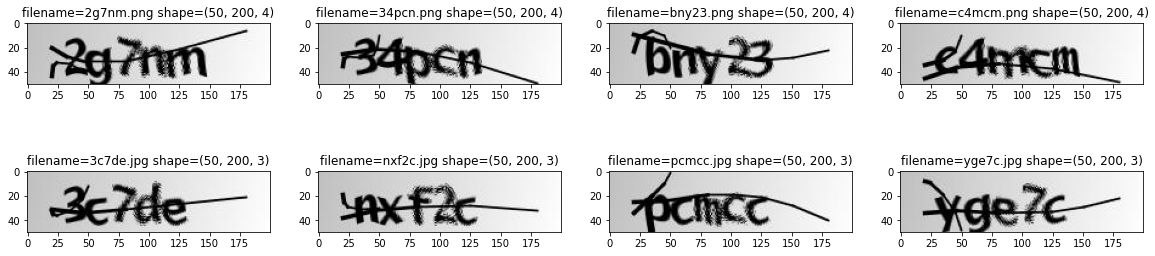

In [3]:
img_2g7nm = mpimg.imread(img_folder + '2g7nm.png')
img_34pcn = mpimg.imread(img_folder + '34pcn.png')
img_bny23 = mpimg.imread(img_folder + 'bny23.png')
img_c4mcm = mpimg.imread(img_folder + 'c4mcm.png')
img_3c7de = mpimg.imread(img_folder + '3c7de.jpg')
img_nxf2c = mpimg.imread(img_folder + 'nxf2c.jpg')
img_pcmcc = mpimg.imread(img_folder + 'pcmcc.jpg')
img_yge7c = mpimg.imread(img_folder + 'yge7c.jpg')
samples = {'2g7nm.png':img_2g7nm, '34pcn.png':img_34pcn, 'bny23.png':img_bny23, 'c4mcm.png':img_c4mcm, 
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'yge7c.jpg':img_yge7c}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

Теперь, глядя на символы в изображениях CAPTCHA, можно заметить, что:
- используется всего 19 символов 2,3,4,5,6,7,8 и b, c, d, e, f, g, m, n, p, w, x, y
- частота каждого символа примерно одинакова, за одним исключением: n используется в два раза чаще, чем другие символы

In [4]:
df = pd.DataFrame(columns=["имя файла", "расширение", "текст", "размер текста", "символ 1", "символ 2", "символ 3", "символ 4", "символ 5"])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,"имя файла"] = f
        df.loc[i,"расширение"] = f.split('.')[1]
        df.loc[i,"текст"] = f.split('.')[0]
        df.loc[i,"размер текста"] = len(f.split('.')[0])
        df.loc[i,"символ 1"] = f.split('.')[0][0]
        df.loc[i,"символ 2"] = f.split('.')[0][1]
        df.loc[i,"символ 3"] = f.split('.')[0][2]
        df.loc[i,"символ 4"] = f.split('.')[0][3]
        df.loc[i,"символ 5"] = f.split('.')[0][4]
        i = i+1
        
df.head()

,имя файла,расширение,текст,размер текста,символ 1,символ 2,символ 3,символ 4,символ 5
0,226md.png,png,226md,5,2,2,6,m,d
1,22d5n.png,png,22d5n,5,2,2,d,5,n
2,2356g.png,png,2356g,5,2,3,5,6,g
3,23mdg.png,png,23mdg,5,2,3,m,d,g
4,23n88.png,png,23n88,5,2,3,n,8,8


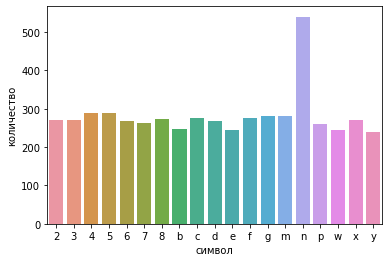

In [5]:
data = pd.DataFrame(df['символ 1'].value_counts()+df['символ 2'].value_counts()+df['символ 3'].value_counts()+df['символ 4'].value_counts()+df['символ 5'].value_counts()).reset_index()
data.columns = ['символ','количество']

sns.barplot(data=data, x='символ', y='количество')
plt.show()

Буду оценивать производительность различных моделей в наборе данных validation, который содержит 10% от полного набора данных.
Для каждого изображения в наборе validation мы сравним исходный текст с предсказанным. Исходный текст и предсказанный являются векторами (5,1). Поэтому мы сравним векторы по элементам и подсчитаем количество достоверных прогнозов по элементам. Для каждого изображения оценка будет равна: количество достоверных прогнозов по элементам / 5.
Рассмотрим пример:
- истинная метка, соответствующая изображению 368y5.png, равна [1 4 6 18 3] после преобразования символов в числовые значения
- если предсказанное значение будет равно [1 4 6 18 3], то оценка для этого изображения будет равна 1
- если предсказанное значение будет равно [2 6 4 10 1], то оценка для этого изображения будет равна 0
- если предсказанное значение будет равно [1 6 6 10 1], то оценка для этого изображение будет равно 0.4 , так как 2 символа предсказаны правильно

Производительность модели будет представлять собой среднее значение баллов для каждого изображения в наборе проверки. Это число соответствует проценту правильно предсказанных символов.

In [6]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Ошибка: размер массивов не совпадает. Не удается вычислить показатель производительности')

**Создание обучающих и валидационных наборов данных**

В этом разделе генерируется обучающий набор, который будет использоваться для обучения нейронной сети, и набор проверки, который будет использоваться для оценки производительности модели.

Обучающий набор будет содержать 90% данных :

X_train с 936 изображениями. Форма X_train будет (936,50,200,1) y_train с 936 метками. форма y_train будет равна (936,5) Набор проверки будет содержать 10% данных

X_val со 104 изображениями. Форма X_val будет (104,50,200,1) y_val со 104 метками. форма y_val будет равна (104,5) Метка, соответствующая каждому изображению, представляет собой строку, соответствующую имени файла за вычетом расширения. Поскольку нейронная сеть имеет дело только с числовыми значениями, нам придется сопоставить каждый символ в строке с целым числом.

In [7]:
# Словари, которые будут использоваться для преобразования символов в целые числа и наоборот
vocabulary = {'2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y'}
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

Эта функция кодирует один образец.

Входные данные :
 - img_path : строка, представляющая путь к изображению, например '/kaggle/input/captcha-version-2-images/samples/samples/6n6gg.jpg '
 - label : строка, представляющая метку, например '6n6gg'
 - crop : логическое значение, если True, изображение обрезается вокруг символов и изменяется до исходного размера.

Выходные данные :
 - многомерный массив, отображающий изображение. Его форма равна (50, 200, 1)
 - массив целых чисел, представляющих метку после кодирования символов в целое число. Например [6,16,6,14,14] для '6n6gg'

In [8]:
def encode_single_sample(img_path, label, crop):
    # Считывает файл изображения и возвращает тензор с dtype=string
    img = tf.io.read_file(img_path)
    # Декодирование и преобразование в оттенки серого (это преобразование не приводит к потере какой-либо информации и уменьшает размер тензора)
    # Эта функция декодирования возвращает тензор с dtype=uint8
    img = tf.io.decode_png(img, channels=1) 
    # Масштабирует и возвращает тензор с dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Обрезка и изменение размера до исходного размера :
    # верхний левый угол = offset_height, offset_width на изображении = 0, 25
    # нижний правый угол находится на offset_height + target_height, offset_width + target_width = 50, 150
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)
    # Транспонировать изображение, потому что мы хотим, чтобы измерение времени соответствовало ширине изображения.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Преобразует строковую метку в массив с 5 целыми числами. Например, '6n6gg' преобразуется в [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label

In [9]:
def create_train_and_validation_datasets(crop=False):
    # Цикл для всех файлов, чтобы создать X, форма которого равна (1040, 50, 200, 1), и y, форма которого равна (1040, 5)
    X, y = [],[]

    for _, _, files in os.walk(img_folder):
        for f in files:
            # Для начала давайте проигнорируем изображения в формате jpg
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension=='png':
                img, label = encode_single_sample(img_folder+f, label,crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)

    #Разделим X, y, чтобы получить X_train, y_train, X_val, y_val
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(1040, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_val = X_train.reshape(936,200,50,1), X_val.reshape(104,200,50,1)
    return X_train, X_val, y_train, y_val

Проверим несколько примеров :

изображения в 1-й строке транспонируются, обрезаются вокруг символов и изменяются в соответствии с ожиданиями "подобной классификатору" модели
изображения во 2-й строке транспонируются только в соответствии с ожиданиями модели CNN LSTM

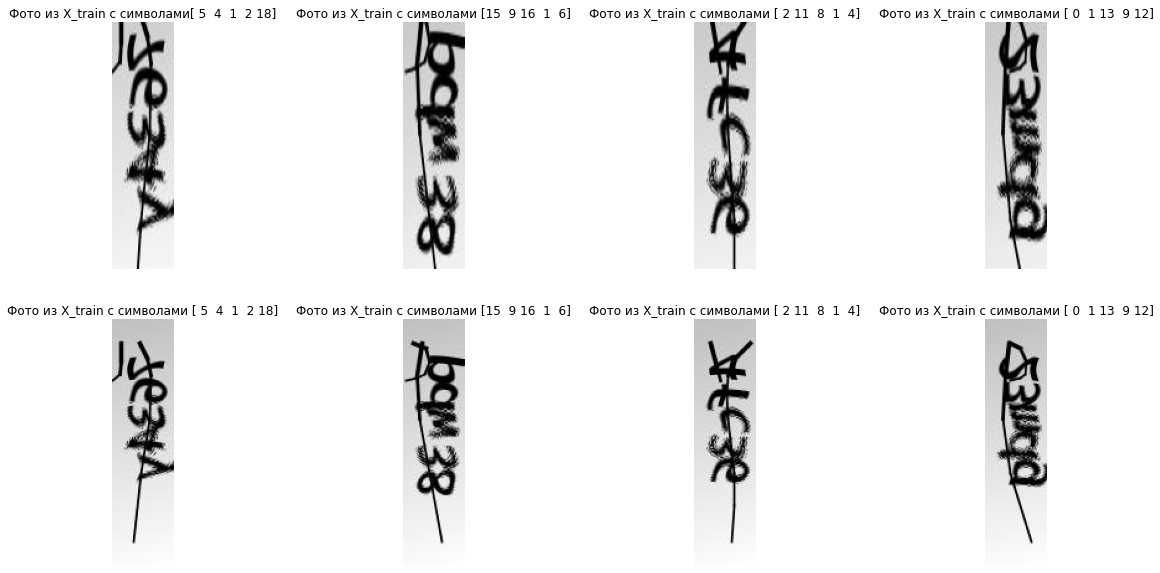

In [11]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
X_train_, X_val_, y_train_, y_val_ = create_train_and_validation_datasets(crop=False)

fig=plt.figure(figsize=(20, 10))
fig.add_subplot(2, 4, 1)
plt.imshow(X_train[0], cmap='gray')
#plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
plt.title('Фото из X_train с символами'+ str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X_train[935], cmap='gray')
#plt.imshow(X_train[935].transpose((1,0,2)), cmap='gray')
plt.title('Фото из X_train с символами '+ str(y_train[935]))
plt.axis('off')
fig.add_subplot(2, 4, 3)
plt.imshow(X_val[0], cmap='gray')
#plt.imshow(X_val[0].transpose((1,0,2)), cmap='gray')
plt.title('Фото из X_train с символами '+ str(y_val[0]))
plt.axis('off')
fig.add_subplot(2, 4, 4)
plt.imshow(X_val[103], cmap='gray')
#plt.imshow(X_val[103].transpose((1,0,2)), cmap='gray')
plt.title('Фото из X_train с символами '+ str(y_val[103]))
plt.axis('off')
fig.add_subplot(2, 4, 5)
plt.imshow(X_train_[0], cmap='gray')
plt.title('Фото из X_train с символами '+ str(y_train_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 6)
plt.imshow(X_train_[935], cmap='gray')
plt.title('Фото из X_train с символами '+ str(y_train_[935]))
plt.axis('off')
fig.add_subplot(2, 4, 7)
plt.imshow(X_val_[0], cmap='gray')
plt.title('Фото из X_train с символами '+ str(y_val_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 8)
plt.imshow(X_val_[103], cmap='gray')
plt.title('Фото из X_train с символами '+ str(y_val_[103]))
plt.axis('off')
plt.show()

**Модель 1, сочетает в себе классификатор CNN и FC**

Строим модель

In [12]:
def build_model():
    
    # Входные данные для модели
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # Первый блок conv
    x = layers.Conv2D(32,(3, 3),activation="sigmoid",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Второй блок conv
    x = layers.Conv2D(64,(3, 3),activation="sigmoid",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    # Использовалось два максимальных пула с размером пула и шагами 2.
    # Следовательно, карты объектов с пониженной дискретизацией в 4 раза меньше. Количество
    # фильтров в последнем слое 64 --> форма выходного объема = (50,12,64)
    # Изменим форму, чтобы "разделить" на 5 временных шагов
    
    x = layers.Reshape(target_shape=(5, 7680), name="reshape")(x)

    # Слои FC
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Выходной слой
    output = layers.Dense(19, activation="softmax", name="dense3")(x) 
    
    # Определим модель
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
   # Скомпилируем модель и вернём
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


model = build_model()
model.summary()

Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 5, 7680)           0         
                                                                 
 dense1 (Dense)              (None, 5, 2

In [13]:
%%time
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
30/30 [==============================] - 9s 279ms/step - loss: 3.3486 - accuracy: 0.0643 - val_loss: 2.9447 - val_accuracy: 0.0981
Epoch 2/30
30/30 [==============================] - 10s 325ms/step - loss: 2.9349 - accuracy: 0.0979 - val_loss: 2.9234 - val_accuracy: 0.1000
Epoch 3/30
30/30 [==============================] - 12s 382ms/step - loss: 2.9308 - accuracy: 0.1041 - val_loss: 2.9216 - val_accuracy: 0.0981
Epoch 4/30
30/30 [==============================] - 11s 368ms/step - loss: 2.9112 - accuracy: 0.1015 - val_loss: 2.9032 - val_accuracy: 0.0981
Epoch 5/30
30/30 [==============================] - 8s 270ms/step - loss: 2.8684 - accuracy: 0.1122 - val_loss: 2.8071 - val_accuracy: 0.1442
Epoch 6/30
30/30 [==============================] - 10s 350ms/step - loss: 2.6777 - accuracy: 0.1731 - val_loss: 2.5139 - val_accuracy: 0.2192
Epoch 7/30
30/30 [==============================] - 10s 335ms/step - loss: 2.3155 - accuracy: 0.2618 - val_loss: 2.1713 - val_accuracy: 0.2596
E

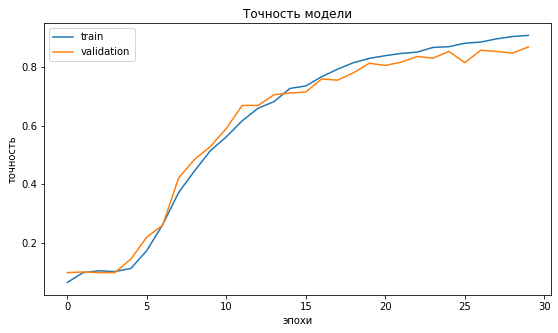

In [14]:
fig=plt.figure(figsize=(20, 5))
#график точности
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('эпохи')
plt.legend(['train', 'validation'], loc='upper left')

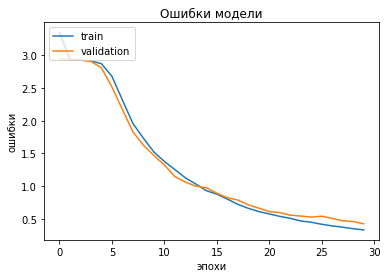

In [15]:
#график потери
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Ошибки модели')
plt.ylabel('ошибки')
plt.xlabel('эпохи')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Предсказание

Используем эту модель для прогнозирования текста для 104 изображений из валидационного набора:

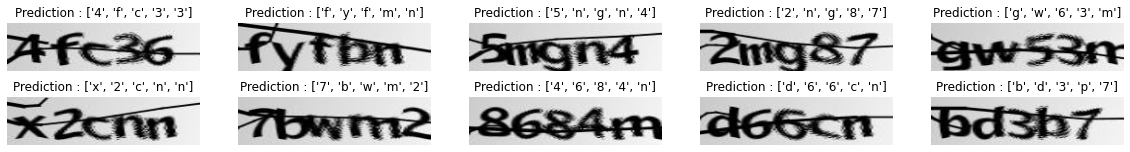

In [16]:
y_pred = model.predict(X_val) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show() 

Производительность модели

Воспользуемся функцией compute_perf_metric для вычисления показателя производительности этой модели. Этот показатель соответствует проценту правильно предсказанных символов.

In [17]:
m1 = compute_perf_metric(y_pred, y_val)
m1

0.8692307692307693

Усовершенствуем модель с помощью изменения параметров.

In [18]:
def build_model():
    
    # Входные данные для модели
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # Первый блок conv
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Второй блок conv
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    # Использовалось два максимальных пула с размером пула и шагами 2.
    # Следовательно, карты объектов с пониженной дискретизацией в 4 раза меньше. Количество
    # фильтров в последнем слое 64 --> форма выходного объема = (50,12,64)
    # Изменим форму, чтобы "разделить" на 5 временных шагов
    
    x = layers.Reshape(target_shape=(5, 7680), name="reshape")(x)

    # Слои FC
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Выходной слой
    output = layers.Dense(19, activation="softmax", name="dense3")(x) 
    
    # Определим модель
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
   # Скомпилируем модель и вернём
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


model = build_model()
model.summary()

Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 5, 7680)           0         
                                                                 
 dense1 (Dense)              (None, 5, 2

Обучим модель

In [19]:
%%time
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
30/30 [==============================] - 8s 257ms/step - loss: 3.1192 - accuracy: 0.1528 - val_loss: 2.2058 - val_accuracy: 0.3365
Epoch 2/30
30/30 [==============================] - 7s 246ms/step - loss: 1.3226 - accuracy: 0.6282 - val_loss: 0.8757 - val_accuracy: 0.7231
Epoch 3/30
30/30 [==============================] - 7s 247ms/step - loss: 0.5515 - accuracy: 0.8447 - val_loss: 0.4646 - val_accuracy: 0.8596
Epoch 4/30
30/30 [==============================] - 7s 250ms/step - loss: 0.3553 - accuracy: 0.8985 - val_loss: 0.4002 - val_accuracy: 0.8654
Epoch 5/30
30/30 [==============================] - 7s 235ms/step - loss: 0.2526 - accuracy: 0.9259 - val_loss: 0.3585 - val_accuracy: 0.8865
Epoch 6/30
30/30 [==============================] - 7s 235ms/step - loss: 0.1953 - accuracy: 0.9429 - val_loss: 0.3195 - val_accuracy: 0.9096
Epoch 7/30
30/30 [==============================] - 7s 241ms/step - loss: 0.1372 - accuracy: 0.9611 - val_loss: 0.2832 - val_accuracy: 0.9192
Epoch 

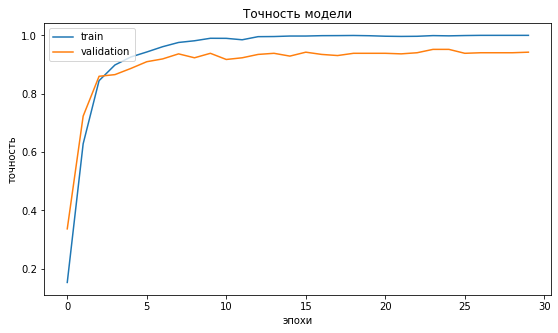

In [20]:
fig=plt.figure(figsize=(20, 5))
#график точности
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('эпохи')
plt.legend(['train', 'validation'], loc='upper left')

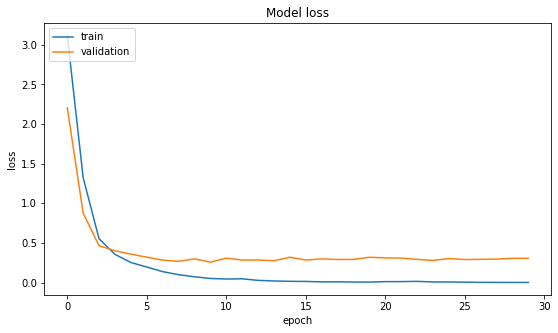

In [21]:
fig=plt.figure(figsize=(20, 5))
#график потери
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Предсказание

Используем эту модель для прогнозирования текста для 104 изображений из валидационного набора:

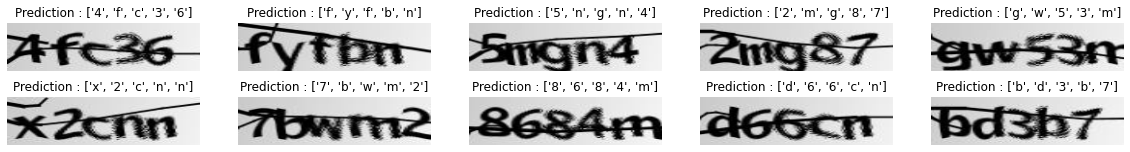

In [22]:
y_pred = model.predict(X_val) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show() 

Производительность модели

Воспользуемся функцией compute_perf_metric для вычисления показателя производительности этой модели. 
Этот показатель соответствует проценту правильно предсказанных символов.

In [23]:
m2 = compute_perf_metric(y_pred, y_val)
m2

0.9423076923076923

In [24]:
print(f"Производительность модели улучшилась на {round(((m2/m1)-1)*100)} %")

Производительность модели улучшилась на 8 %


Модель 2, CNN LSTM с функцией CTC

Это решение реализует архитектуру CNN LSTM с потерей CTC и обеспечивает высокую производительность (>99%).

Строим модель

In [25]:
# Создадим новый CTCLayer, создав подкласс
class CTCLayer(layers.Layer):
        
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        

    def call(self, y_true, y_pred):
        # Вычислите значение потери времени обучения и добавьте его в слой, используя `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Во время тестирования просто верните вычисленные прогнозы
        return y_pred

def build_model():
    
    # Входные данные для модели
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Первый блок conv
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Второй блок conv
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Мы использовали два максимальных пула с размером пула и шагами 2.
    # Следовательно, карты объектов с пониженной дискретизацией в 4 раза меньше. Количество фильтров в последнем слое равно 64. Измените форму соответствующим образом, прежде чем
    # передача выходных данных в RNN-часть модели
    x = layers.Reshape(target_shape=(50, 768), name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Выходной слой
    x = layers.Dense(20, activation="softmax", name="dense2")(x) # 20 = 19 characters + UKN
    

    # Добавим слой CTC для расчета потерь CTC на каждом шаге
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Определим модель
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_cnn_lstm_model")
    
   # Скомпилируем модель и вернём
    model.compile(optimizer=keras.optimizers.Adam())
    return model


# Получим модель
model = build_model()
model.summary()

Model: "ocr_cnn_lstm_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]'] 

Обучение модели

In [26]:
%%time
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=False)

# Добавим раннюю остановку
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# Обучим модель
history = model.fit([[X_train, y_train]], validation_data=[[X_val, y_val]], epochs=30, callbacks=[early_stopping])

Epoch 1/30
30/30 [==============================] - 21s 498ms/step - loss: 24.9188 - val_loss: 16.5433
Epoch 2/30
30/30 [==============================] - 10s 326ms/step - loss: 16.3585 - val_loss: 16.3386
Epoch 3/30
30/30 [==============================] - 10s 336ms/step - loss: 16.3193 - val_loss: 16.3298
Epoch 4/30
30/30 [==============================] - 9s 316ms/step - loss: 16.3149 - val_loss: 16.3380
Epoch 5/30
30/30 [==============================] - 11s 358ms/step - loss: 16.3105 - val_loss: 16.3309
Epoch 6/30
30/30 [==============================] - 9s 302ms/step - loss: 16.3114 - val_loss: 16.3698
Epoch 7/30
30/30 [==============================] - 10s 325ms/step - loss: 16.3123 - val_loss: 16.3104
Epoch 8/30
30/30 [==============================] - 9s 303ms/step - loss: 16.3010 - val_loss: 16.2906
Epoch 9/30
30/30 [==============================] - 9s 315ms/step - loss: 16.2570 - val_loss: 16.2826
Epoch 10/30
30/30 [==============================] - 9s 304ms/step - loss: 16

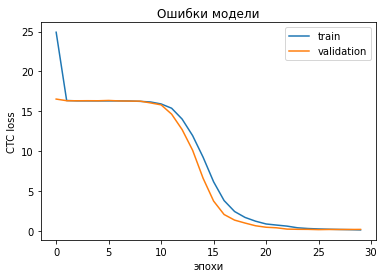

In [29]:
#график потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Ошибки модели')
plt.ylabel('CTC loss')
plt.xlabel('эпохи')
plt.legend(['train', 'validation'])
plt.show()

In [30]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

Предсказание

In [31]:
y_pred = prediction_model.predict(X_val)
y_pred = keras.backend.ctc_decode(y_pred, input_length=np.ones(104)*50, greedy=True) 
y_pred = y_pred[0][0][0:104,0:5].numpy()

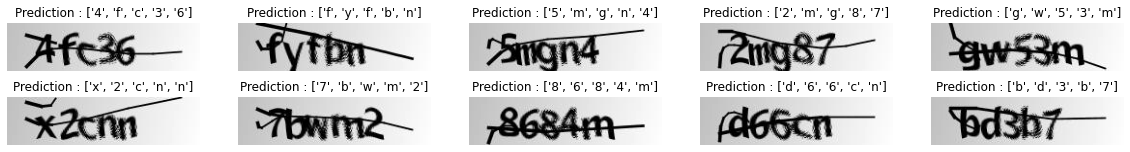

In [32]:
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show()    

Производительность модели

Воспользуемся функцией compute_perf_metric для вычисления показателя производительности этой модели. Этот показатель соответствует проценту правильно предсказанных символов.

In [33]:
compute_perf_metric(y_pred, y_val)

0.9961538461538462

Вывод: 
    Самая производительная модель - CNN LSTM с функцией CTC. Производительность - 99%